In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../src/')
from gsm import GSM
from advi import ADVI
from pathfinder import Pathfinder
#####                                                                                                                                                         



/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sys.path.append('../../posterior_database/')
from posteriordb import PDB, BSDB

# Simple multivariate Gaussian

In [5]:
##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D**2).reshape(D, D)
    cov = np.matmul(L, L.T) + np.eye(D)*1e-3
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))

    return mean, cov, lp, lp_g


D = 5
mean, cov, lp, lp_g = setup_model(D)
ref_samples = np.random.multivariate_normal(mean, cov, 5000)

In [6]:
def gsm_fit(D, lp, lp_g, niter=1000):

    gsm = GSM(D=D, lp=lp, lp_g=lp_g)
    key = random.PRNGKey(99)
    mean_fit, cov_fit = gsm.fit(key, niter=niter)

    return mean_fit, cov_fit

def advi_fit(D, lp, lp_g, lr=1e-2, batch_size=16, niter=1000):

    advi = ADVI(D=D, lp=lp)
    key = random.PRNGKey(99)
    opt = optax.adam(learning_rate=lr)
    mean_fit, cov_fit, losses = advi.fit(key, opt, batch_size=batch_size, niter=niter)

    return mean_fit, cov_fit



def pathfinder_fit(D, lp, lp_g, maxiter=1000, batch_kl=32):

    finder = Pathfinder(D=D, lp=lp, lp_g=lp_g)
    key = random.PRNGKey(99)
    mean_fit, cov_fit, trajectory = finder.fit(key, maxiter=maxiter, return_trajectory=True)

    return mean_fit, cov_fit



In [7]:
params = {}
alg = "gsm"
params[alg] = gsm_fit(D, lp, lp_g)

alg = "advi"
params[alg] = advi_fit(D, lp, lp_g)

alg = "path"
params[alg] = pathfinder_fit(D, lp, lp_g)

Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000
Output of LBFGS run is 
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 4.5133828912355245
        x: [ 9.396e-01  4.607e-01  1.140e-01  4.557e-01  1.102e-01]
      nit: 20
      jac: [-3.012e-06  2.404e-06 -1.089e-06 -7.014e-06 -8.655e-07]
     nfev: 21
     njev: 21
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
KL minimized at iteration 4


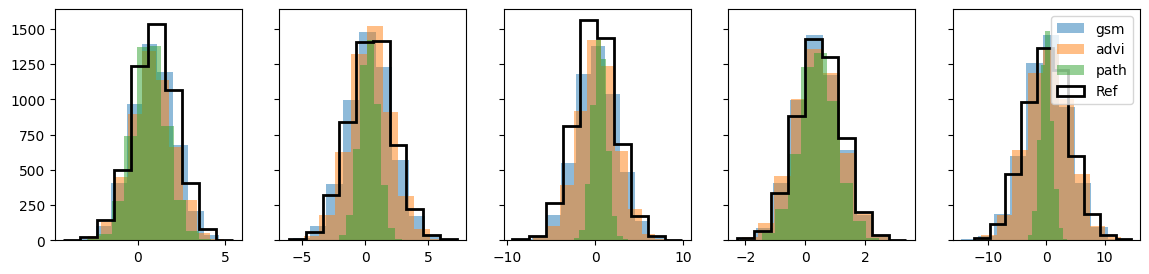

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(14, 3), sharey=True)

for alg in params.keys():
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    for i in range(D):
        ax[i].hist(samples[:, i], alpha=0.5, label=alg)
for i in range(D):
    ax[i].hist(ref_samples[:, i], alpha=1.0, label='Ref', lw=2, histtype='step', color='k')
ax[-1].legend()

# PosteriorDB models

In [17]:
for i, j in enumerate(names):
    if 'earnings' in j: print(i, j)

5 earnings-logearn_logheight_male
6 earnings-logearn_interaction_z
24 earnings-earn_height
50 earnings-log10earn_height
52 earnings-logearn_interaction
65 earnings-logearn_height_male
90 earnings-logearn_height


In [9]:
sys.path.append('../utils/')
from monitors import backward_kl, forward_kl

In [10]:
names = np.loadtxt('../../posterior_database/pdbnames.txt', dtype='str')
failed_models = [11, 18, 20, 25, 38, 43, 46, 57, 67, 69, 74, 77, 91]
failed_models = failed_models + [26, 40, 51, 53, 60]

In [11]:
class Results():
    def __init__(self, ):
        self.params = {}
        self.samples = {}
        self.fkl = {}
        self.bkl = {}
        self.losses = {}    
        self.algs = []

def load_results(model_n):
    results = Results()
    if model_n in failed_models:
        print('Failed model')
        return results
    try:
        model = BSDB(model_n)
        results.ref_samples = model.samples_unc.copy()
    except Exception as e:
        print(e)
        return None
    
    results.D = model.dims
    
    for alg in ['gsm', 'gsm-lbinit', 'advi', 'advi-lbinit' ,'path', 'path_bjax']:
        try:
            mu = np.load(f"/mnt/ceph/users/cmodi/polyakVI/pathfinder/PDB_{model_n}/{alg}_mean.npy")
            cov = np.load(f"/mnt/ceph/users/cmodi/polyakVI/pathfinder/PDB_{model_n}/{alg}_cov.npy")
            loss = np.load(f"/mnt/ceph/users/cmodi/polyakVI/pathfinder/PDB_{model_n}/{alg}_loss.npy")
            samples = np.random.multivariate_normal(mu, cov, 1000)
            results.losses[alg] = loss
            results.params[alg] = [mu, cov]
            results.samples[alg] = samples
            try:
                with open(f"/mnt/ceph/users/cmodi/polyakVI/pathfinder/PDB_{model_n}/bkl.json", 'r') as fp:
                    results.bkl = json.load(fp)
                with open(f"/mnt/ceph/users/cmodi/polyakVI/pathfinder/PDB_{model_n}/fkl.json", 'r') as fp:
                    results.fkl = json.load(fp)
            except Exception as e:
                q = MultivariateNormal(mu, cov)
                results.bkl[alg] = backward_kl(samples[:1000], q.log_prob, model.lp)
                results.fkl[alg] = forward_kl(results.ref_samples[:1000], q.log_prob, model.lp)
            results.algs.append( alg)
        except Exception as e:
            print(e)

    
    return results


res = load_results(0)
print(res.D)

Model name : Model_00
10


In [12]:
# all_results = {}
# for i in range(0, 103):
#     res = load_results(i)
#     if res is not None:
#         all_results[i] = res

In [120]:
# import json

# model_n = 0
# for model_n in range(102):
#     print(model_n)
#     try:
#         res = all_results[model_n]
#         #
#         data = res.bkl.copy()
#         for k in data.keys(): 
#             data[k] = float(data[k])        
#         with open(f"/mnt/ceph/users/cmodi/polyakVI/pathfinder/PDB_{model_n}/bkl.json", 'w') as fp:
#             json.dump(data, fp, indent=4)
#         #
#         data = res.fkl.copy()
#         for k in data.keys(): 
#             data[k] = float(data[k])        
#         with open(f"/mnt/ceph/users/cmodi/polyakVI/pathfinder/PDB_{model_n}/fkl.json", 'w') as fp:
#             json.dump(data, fp, indent=4)
#     except Exception as e:
#         print(e)

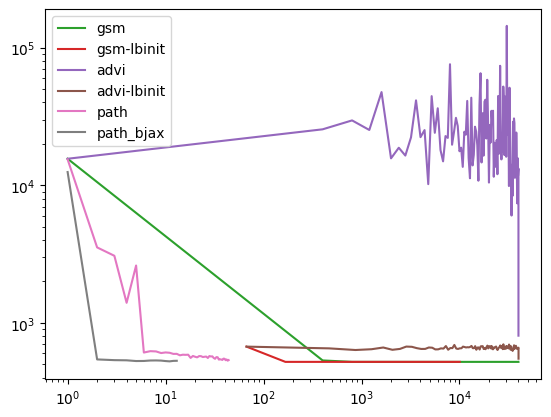

In [19]:
# i = 1
# for alg in res.algs:
#     i+=1
#     plt.plot(res.losses[alg][0], res.losses[alg][1], f'C{i}', label=alg)
#     plt.plot(res.losses[alg][0], -res.losses[alg][1], f'C{i}--',  )
       
# plt.loglog()
# plt.legend()

In [13]:
# i = 0
# idim = 2
# nbins = 20 
# # for alg in res.algs:
# for alg in ['gsm', 'advi', 'path', 'path_bjax', ]:
#     plt.hist(res.samples[alg][:, idim], color=f'C{i}', label=alg, alpha=0.7-0.1*i, density=True, bins=nbins)
#     i+=1
# n, bins, _ = plt.hist(res.ref_samples[:, idim], density=True, lw=2, color='k', histtype='step', bins=nbins)
# plt.ylim(0, n.max()*1.2)
# plt.xlim(bins.min(), bins.max())
# # plt.loglog()
# plt.legend()

In [20]:
### HORIZONTAL ORIENTATION

# plt.figure(figsize=(15, 4))
# for i in range(101):
#     try:
#         res = all_results[i]
#         if 'gsm' in res.bkl.keys(): 
#             plt.plot(i, res.bkl['gsm'], 'C0x')
#         else:
#             plt.plot(i, 0, 'C0x')
#         if 'gsm-lbinit' in res.bkl.keys(): 
#             plt.plot(i, res.bkl['gsm-lbinit'], 'C1x')
#         else:
#             plt.plot(i, 0, 'C1x')
#         if 'path' in res.bkl.keys(): 
#             plt.plot(i, res.bkl['path'], 'k.')
#         else:
#             plt.plot(i, 0, 'k.')
#     except Exception as e:
#         print(e)
#         plt.plot(i, 0, 'C0x')
#         plt.plot(i, 0, 'C1.')

# plt.yscale('symlog')
# plt.ylim(-1e4, 1e7)
# plt.xticks(np.arange(0, 100, 2), names[:100:2], rotation=90)
# plt.grid(which='both')
# plt.ylabel('$\sum_{x\sim q} \log q(x) - \log p(x)$', fontsize=11)
# plt.show()




# plt.figure(figsize=(15, 4))
# for i in range(101):
#     try:
#         res = all_results[i]
#         if 'gsm' in res.fkl.keys(): 
#             plt.plot(i, res.fkl['gsm'], 'C0x')
#         else:
#             plt.plot(i, 0, 'C0x')

#         if 'gsm-lbinit' in res.fkl.keys(): 
#             plt.plot(i, res.fkl['gsm-lbinit'], 'C1x')
#         else:
#             plt.plot(i, 0, 'C1x')

#         if 'path' in res.fkl.keys(): 
#             plt.plot(i, res.fkl['path'], 'k.')
#         else:
#             plt.plot(i, 0, 'k.')

#     except Exception as e:
#         plt.plot(i, 0, 'C0x')
#         plt.plot(i, 0, 'C1.')
#         print(e)
# plt.yscale('symlog')
# # plt.ylim(-1e6, 1e6)
# plt.ylim(-1e5, 1e10)
# plt.xticks(np.arange(0, 100, 2))
# plt.grid(which='both')
# plt.ylabel('$\sum_{x\sim p} \log p(x) - \log q(x)$', fontsize=11)
# plt.show()


# compare KLs

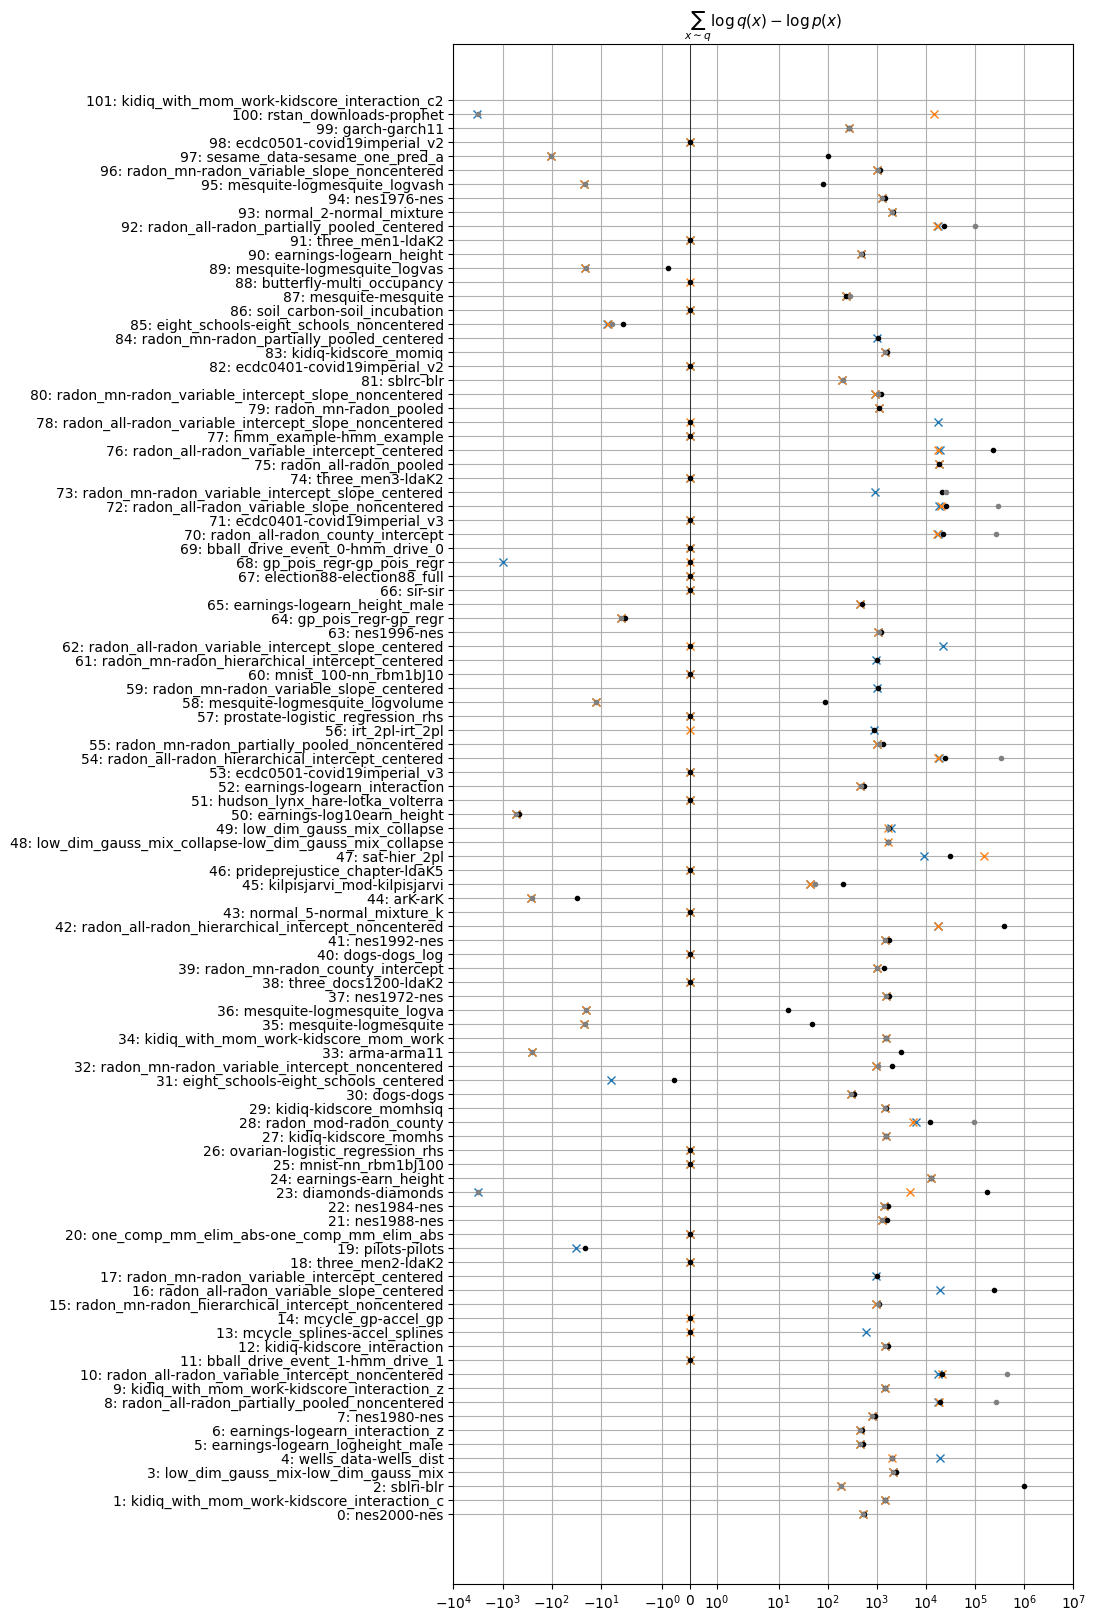

In [14]:
plt.figure(figsize=(8, 20))
for i in range(101):
    try:
        res = all_results[i]
        if 'gsm' in res.bkl.keys(): 
            plt.plot(res.bkl['gsm'], i, 'C0x')
        else:
            plt.plot(0, i, 'C0x')
        if 'gsm-lbinit' in res.bkl.keys(): 
            plt.plot(res.bkl['gsm-lbinit'], i, 'C1x')
        else:
            plt.plot(0, i, 'C1x')
        if 'path' in res.bkl.keys(): 
            plt.plot(res.bkl['path'], i, 'k.')
        else:
            plt.plot(0, i, 'k.')
        if 'path_bjax' in res.bkl.keys(): 
            plt.plot(res.bkl['path_bjax'], i, marker='.', color='grey')
        else:
            pass 
            #plt.plot(0, i,  marker='.', color='grey')
    except Exception as e:
        # print(e)
        # plt.plot(0, i, 'C0x')
        plt.plot(0, i, 'k*')
        pass

plt.axvline(0, color='k', lw=0.5)
plt.xscale('symlog')
plt.xlim(-1e4, 1e7)
plt.yticks(np.arange(0, 102, 1), [f'{i}: ' + names[i] for i in range(102)])
plt.grid(which='both')
plt.title('$\sum_{x\sim q} \log q(x) - \log p(x)$', fontsize=11)
plt.show()


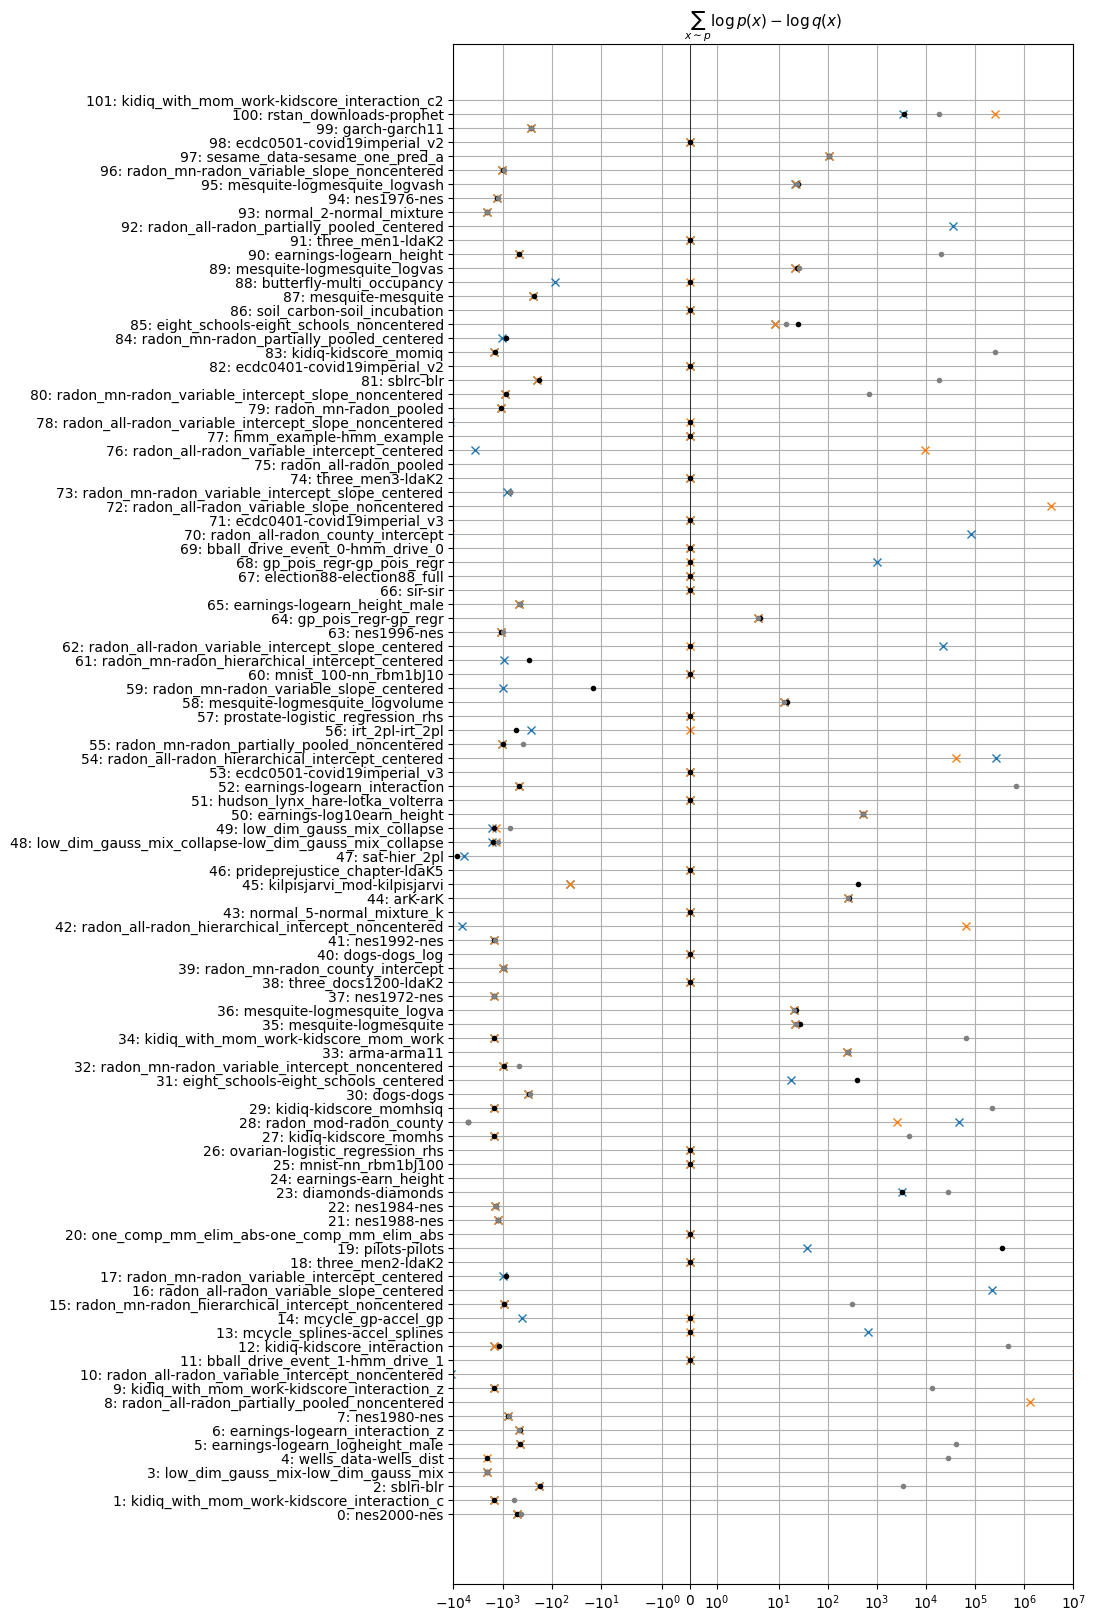

In [15]:
plt.figure(figsize=(8, 20))
for i in range(101):
    try:
        res = all_results[i]
        if 'gsm' in res.bkl.keys(): 
            plt.plot(res.fkl['gsm'], i, 'C0x')
        else:
            plt.plot(0, i, 'C0x')
        if 'gsm-lbinit' in res.bkl.keys(): 
            plt.plot(res.fkl['gsm-lbinit'], i, 'C1x')
        else:
            plt.plot(0, i, 'C1x')
        if 'path' in res.bkl.keys(): 
            plt.plot(res.fkl['path'], i, 'k.')
        else:
            plt.plot(0, i, 'k.')
        if 'path_bjax' in res.fkl.keys(): 
            plt.plot(res.fkl['path_bjax'], i, marker='.', color='grey')
        else:
            pass
            #plt.plot(0, i,  marker='.', color='grey')
    except Exception as e:
        print(e)
        plt.plot(0, i, 'k*')
        # plt.plot(0, i, 'C0x')
        # plt.plot(0, i, 'C1.')

plt.xscale('symlog')
plt.xlim(-1e4, 1e7)
plt.yticks(np.arange(0, 102, 1), [f'{i}: ' + names[i] for i in range(102)])
plt.grid(which='both')
plt.axvline(0, color='k', lw=0.5)
plt.title('$\sum_{x\sim p} \log p(x) - \log q(x)$', fontsize=11)
plt.show()


earnings-logearn_logheight_male
Dimensionality of the problem :  4
[1 2 1 2]


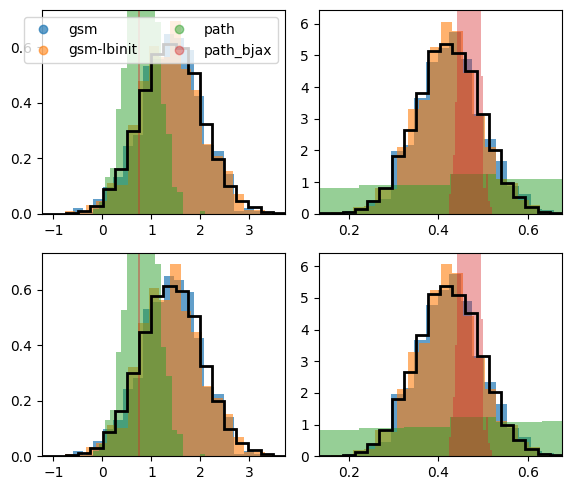

In [18]:
model_n = 5
res = all_results[model_n]
print(names[model_n])
print("Dimensionality of the problem : ", res.D)
D_plot= min(20, res.D)

nrows = 2
fig, ax = plt.subplots(nrows, D_plot//nrows, figsize=(D_plot//nrows*3, 2.5*nrows), sharey=False)


idx = np.random.randint(0, res.D, ax.size)
# idx = np.arange(0, res.D)
print(idx)

nbins = 20 
for i in range(ax.size):
    axis = ax.flatten()[i]
    n, bins, _ = axis.hist(res.ref_samples[:, idx[i]], histtype='step', lw=2, color='k', density=True, bins=nbins)
    ia = 0
    for key in ['gsm',  'gsm-lbinit', 'path', 'path_bjax']:
        try: 
            axis.hist(res.samples[key][:, idx[i]], color=f'C{ia}', alpha= 0.7-0.1*ia, density=True, bins=nbins)
        except : 
            pass 
        if i == 0:
            axis.plot(np.NaN, np.NaN, f'C{ia}o', alpha= 0.7-0.1*ia, label=key)
        ia +=1
    axis.set_ylim(0, n.max()*1.2)
    axis.set_xlim(bins.min(), bins.max())

ax.flatten()[0].legend(ncol=2)
plt.tight_layout()

earnings-logearn_logheight_male
Dimensionality of the problem :  4
Histogram for dimension 61


IndexError: index 61 is out of bounds for axis 1 with size 4

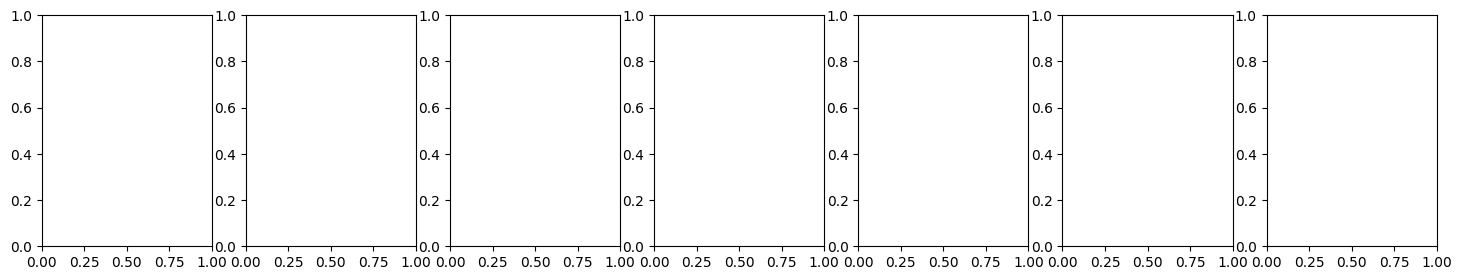

In [17]:
# model_n = 100
idim = 61
res = all_results[model_n]
print(names[model_n])
print("Dimensionality of the problem : ", res.D)
D_plot= min(20, res.D)

algs = ['gsm', 'gsm-lbinit', 'advi', 'advi-lbinit', 'path', 'path_bjax']
nalgs = len(algs)

print(f"Histogram for dimension {idim}")
fig, ax = plt.subplots(1, 1+len(algs), figsize=(3*nalgs, 3))

ax[0].hist(res.ref_samples[:, idim], histtype='step', lw=2, color='k', density=True)
for j in range(nalgs):
    try:
        # ax[j+1].hist(res.ref_samples[:, idim], histtype='step', lw=2, color='k', density=True)
        ax[j+1].hist(res.samples[algs[j]][:, idim], alpha=0.5, density=True, label=key)
    except Exception as e:
        print(e)
    ax[j+1].set_title(algs[j])
    
# plt.yscale('log')
for axis in ax:
    axis.grid()
# axis.set_xlim(res.ref_samples[:, i].min(), res.ref_samples[:, i].max())
# ax[0, 0].legend(ncol=5, bbox_to_anchor=(3, 1.2))
# plt.tight_layout()

# single model

In [5]:
from initializers import lbfgs_init
from gsm import gsm_update

In [6]:
sys.path.append('/mnt/home/cmodi/Research/Projects/posterior_database/')
from posteriordb import BSDB
from jax_utils import jaxify_bs
names = np.loadtxt('../../posterior_database/pdbnames.txt', dtype='str')


In [49]:
# model_n = 87 #mesquite
# model_n = 51 #hudon lynx
# model_n = 24 #earnings_earn_height
# model_n = 45 #kilpisjarvi_mod

model_n = 8
print(names[model_n])
model = BSDB(model_n)
D = model.dims
lpjax, lp_itemjax = jaxify_bs(model)
lp = model.lp
lp_g = lambda x: model.lp_g(x)[1]
lpjaxsum = jit(lambda x: jnp.mean(lpjax(x)))
ref_samples = model.samples_unc.copy()

seed = 0 
np.random.seed(seed)
rng = jax.random.PRNGKey(seed)
print("ref samples shape : ", model.samples_unc.shape)

radon_all-radon_partially_pooled_noncentered
Model name : Model_08
ref samples shape :  (10000, 389)


In [50]:
# x0 = np.ones(D)
# mu_init, cov_init, res = lbfgs_init(x0, lp, lp_g, maxfun=10000, maxiter=10000, verbose=True)
# print(mu_init)
# print(cov_init)

In [51]:
def check_cov(mu_new, cov_new, mu_update, cov_update, det_thresh=1e-16):

    # det = np.linalg.det(cov_new)
    # if abs(det) < det_thresh:
    #     print("0 determinant")
    #     return  mu_update, cov_update 
    try:
        if (np.isnan(np.linalg.cholesky(cov_new))).any():            
            print("nan in cholesky")
            return mu_update, cov_update
        else:
            return mu_new, cov_new
    except Exception as e:
        print("Exception in checking cov : ", e)
        return mu_update, cov_update


In [52]:
key = jax.random.PRNGKey(0)
start = time.time()
niter = 500
loss = []
# mu_fit, cov_fit = np.zeros(D), np.identity(D)*1.0
mu_fit, cov_fit = np.random.normal(size=D), np.identity(D)*1.0
# mu_fit, cov_fit = mu_init, np.identity(D)*0.1
batch = 4

for j in range(niter + 1):
    if j%(niter//10) == 0 : 
        print(j)
        
    key, key_fit = random.split(key, 2)
    samples = np.random.multivariate_normal(mean=mu_fit, cov=cov_fit, size=batch)#.reshape(batch, -1)
    vs = lp_g(samples)
    mu_new, cov_new = gsm_update(samples, vs, mu_fit*1., cov_fit*1.)
    mu_fit, cov_fit = check_cov(mu_new, cov_new, mu_fit, cov_fit)

# print(mu_fit, cov_fit)
q = dist.MultivariateNormal(loc=mu_fit, covariance_matrix=cov_fit)
ssfit = q.sample(key, (5000,))
print(f"Time taken {time.time()-start}")    



0
50
100
150
200
250
300
350
400
450
500
Time taken 41.925490617752075


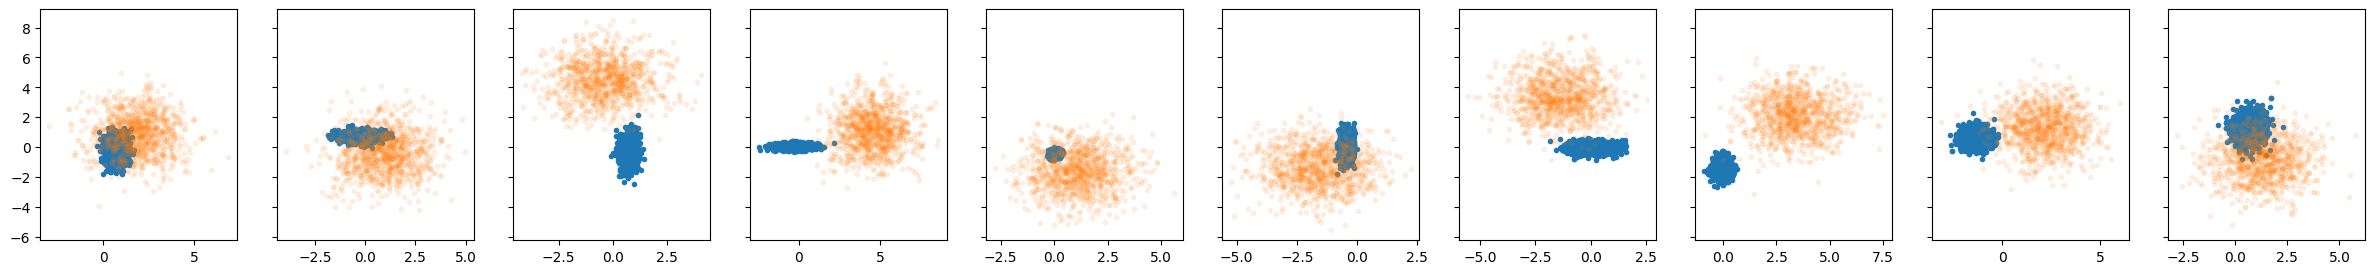

In [53]:

############
Dplot = min(D-1, 10)
fig, ax = plt.subplots(1, Dplot, figsize=(Dplot*3, 3), sharey=True)
npts = 1000 
for j in range(Dplot):
    ax[j].plot(ref_samples[:npts,j], ref_samples[:npts, j+1], '.', alpha=1.)
    ax[j].plot(ssfit[:npts,j], ssfit[:npts, j+1], '.', alpha=0.1)
    # ax[j].plot(ssmix[:npts,j], ssmix[:npts, j+1], '.', alpha=0.1)       
plt.show()


In [54]:
fig, ax = plt.subplots(1, D, figsize=(D*3, 3))

for i in range(D):
    ax[i].hist(ref_samples[:, i], bins=50, density=True)
    ax[i].hist(ssfit[:, i], bins=50, alpha=0.5, density=True)
    

ValueError: Image size of 116700x300 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 116700x300 with 389 Axes>